In [9]:
# imports 

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from keras.applications import VGG16, DenseNet121, MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.spatial.distance import cdist


from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Lambda, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import preprocess_input
from keras.applications.densenet import preprocess_input
from keras import backend as K
import face_recognition


from keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet
from keras.applications.densenet import preprocess_input as preprocess_input_dense
from keras.models import load_model
import matplotlib.pyplot as plt



In [2]:
print(os.getcwd()) # check Working Directory

/Users/wj7/Desktop/comp90086 computer vision/final project/COMP90086_2023_TLLdataset


In [3]:
# get path


# train_dir_path = "COMP90086_2023_TLLdataset/train"
# test_dir_path = "COMP90086_2023_TLLdataset/test"
train_dir_path = "train"
test_dir_path = "test"

train_left_image_path = os.path.join(train_dir_path, "left")
train_right_image_path = os.path.join(train_dir_path, "right")

test_left_image_path = os.path.join(test_dir_path, "left")
test_right_image_path = os.path.join(test_dir_path, "right")

print("train data")
print(f"Number of left images: {len(os.listdir(train_left_image_path))}")
print(f"Number of right images: {len(os.listdir(train_right_image_path))}")

print("\ntest data")
print(f"Number of left images: {len(os.listdir(test_left_image_path))}")
print(f"Number of right images: {len(os.listdir(test_right_image_path))}")



train data
Number of left images: 2000
Number of right images: 2000

test data
Number of left images: 2000
Number of right images: 2000


In [17]:
#pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 1.4 MB/s eta 0:00:0000:0100:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 1.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp38-cp38-macosx_11_0_x86_64.whl size=3628850 sha256=746966b9f1dac08470a86713f03f508bf0ef6059a5e31e5a14c3f7e1bd7109b8
  Stored in directory: /Users/wj7/Library/Caches/pip/wheels/21/03/71/98fd66c954809f33662e781bd02c4363cced2fa1c76178f812
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=79c1239c4eaebb75f02f5f685b4107c41cd3817a6e6b6db46b345504281495f1
  Stored in directory: /Users/wj7/Library/Caches/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built dlib face-recognition-mode

## 0.563 score
## DenseNet121+MobileNet (extract feature individually)，cosine_triplet_loss，cdist

In [11]:

train_dir_path = "train"
test_dir_path = "test"

train_left_image_path = os.path.join(train_dir_path, "left")
train_right_image_path = os.path.join(train_dir_path, "right")

test_left_image_path = os.path.join(test_dir_path, "left")
test_right_image_path = os.path.join(test_dir_path, "right")



In [12]:
# load premodel
densenet121_model = DenseNet121(weights='imagenet', include_top=False)
densenet121 = Model(inputs=densenet121_model.input, outputs=densenet121_model.layers[-1].output)

mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(200, 245, 3))
mobilenet = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.output)


In [13]:
# feature extract
def extract_features_mobilenet(img_path):
    img = load_img(img_path, target_size=(200, 245))
    img_array = img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input_mobilenet(expanded_img_array)
    return mobilenet.predict(preprocessed_img).flatten()

def extract_features_densenet121(img_path):
    img = load_img(img_path, target_size=(200, 245))
    img_array = img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input_dense(expanded_img_array)
    return densenet121.predict(preprocessed_img).flatten()

def extract_combined_features(img_path):
    features_mobilenet = extract_features_mobilenet(img_path + ".jpg")
    features_densenet121 = extract_features_densenet121(img_path + ".jpg")
    return np.concatenate([features_mobilenet, features_densenet121])

In [35]:
precomputed_features = {}
def get_features(img_path):
    if img_path not in precomputed_features:
        precomputed_features[img_path] = extract_combined_features(img_path)
    return precomputed_features[img_path]



def prepare_features_and_labels(train_left_image_path, train_right_image_path, train_csv_path):
    train_df = pd.read_csv(train_csv_path)
    all_right_images = train_df["right"].unique()

    anchors, positives, negatives = [], [], []

    for _, row in train_df.iterrows():
        anchor_img_path = os.path.join(train_left_image_path, row["left"])
        positive_img_path = os.path.join(train_right_image_path, row["right"])

        # randomly select a non -matching right image as a negative sample
        negative_img_path = np.random.choice(
            list(set(all_right_images) - set([row["right"]]))
        )
        negative_img_path = os.path.join(train_right_image_path, negative_img_path)

        anchors.append(get_features(anchor_img_path)) 
        positives.append(get_features(positive_img_path))  
        negatives.append(get_features(negative_img_path)) 

    return np.array(anchors), np.array(positives), np.array(negatives)

# 2. model build
#cosine_distance =  1 - cosine similarity

# def cosine_distance(vests):
#     x, y = vests
#     x = tf.nn.l2_normalize(x, axis=-1)
#     y = tf.nn.l2_normalize(y, axis=-1)
#     return -tf.reduce_sum(x * y, axis=-1, keepdims=True)

def cosine_distance(vests):
    x, y = vests
    x = tf.nn.l2_normalize(x, axis=-1)
    y = tf.nn.l2_normalize(y, axis=-1)
    return 1.0 - tf.reduce_sum(x * y, axis=-1, keepdims=True)


def cosine_distance_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# def cosine_triplet_loss(y_true, y_pred, alpha=0.2):
#     anchor, positive, negative = y_pred[:, :feature_length], y_pred[:, feature_length:2*feature_length], y_pred[:, 2*feature_length:]

#     positive_distance = cosine_distance([anchor, positive])
#     negative_distance = cosine_distance([anchor, negative])
        
#     basic_loss = positive_distance - negative_distance + alpha
#     return tf.reduce_mean(tf.maximum(basic_loss, 0.0))

def cosine_triplet_loss(y_true, y_pred, alpha=0.2):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:, :total_lenght//3], y_pred[:, total_lenght//3:2*total_lenght//3], y_pred[:, 2*total_lenght//3:]

    positive_distance = cosine_distance([anchor, positive])
    negative_distance = cosine_distance([anchor, negative])

    basic_loss = positive_distance - negative_distance + alpha
    return tf.reduce_mean(tf.maximum(basic_loss, 0.0))



def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(1024, activation='relu')(input)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    return Model(input, x)



In [36]:
anchors, positives, negatives = prepare_features_and_labels(
    train_left_image_path, train_right_image_path, "train.csv"
)

1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 118ms/step


In [39]:
'''train model '''

feature_length = anchors.shape[1]
base_network = create_base_network((feature_length,))

input_anchor = Input(shape=(feature_length,))
input_positive = Input(shape=(feature_length,))
input_negative = Input(shape=(feature_length,))

processed_anchor = base_network(input_anchor)
processed_positive = base_network(input_positive)
processed_negative = base_network(input_negative)


def cosine_distance_difference(tensors):
    anchor, positive, negative = tensors
    positive_distance = cosine_distance([anchor, positive])
    negative_distance = cosine_distance([anchor, negative])
    return tf.nn.relu(positive_distance - negative_distance)

distance_difference = Lambda(cosine_distance_difference)([processed_anchor, processed_positive, processed_negative])
prediction = Dense(1, activation='sigmoid')(distance_difference)


merged_vector = concatenate([processed_anchor, processed_positive, processed_negative], axis=-1)
siamese_net = Model([input_anchor, input_positive, input_negative], merged_vector)

#siamese_net = Model([input_anchor, input_positive, input_negative], prediction)
siamese_net.compile(optimizer='adam', loss=cosine_triplet_loss) #cosine_triplet_loss


X_train_anchor, X_val_anchor, X_train_positive, X_val_positive, X_train_negative, X_val_negative = train_test_split(
    anchors, positives, negatives, test_size=0.3, random_state=42)

checkpoint = ModelCheckpoint(filepath="cosdists_net121_MobileNet_cosTripletloss_best_weights.h5", 
                             save_best_only=True, save_weights_only=True)


# for tirplet loss need dummys
# y_train_dummy = np.zeros((X_train_anchor.shape[0], 1))
# y_val_dummy = np.zeros((X_val_anchor.shape[0], 1))

y_train_dummy = np.zeros((X_train_anchor.shape[0], feature_length * 3))
y_val_dummy = np.zeros((X_val_anchor.shape[0], feature_length * 3))


history = siamese_net.fit(
    [X_train_anchor, X_train_positive, X_train_negative], 
    y_train_dummy, 
    validation_data=([X_val_anchor, X_val_positive, X_val_negative], y_val_dummy),
    batch_size=32, epochs=15, callbacks=[checkpoint]
)



Epoch 1/15
44/44 [==============================] - 43s 857ms/step - loss: 0.0977 - val_loss: 0.0979
Epoch 2/15
44/44 [==============================] - 32s 719ms/step - loss: 0.0254 - val_loss: 0.0905
Epoch 3/15
44/44 [==============================] - 36s 823ms/step - loss: 0.0079 - val_loss: 0.0922
Epoch 4/15
44/44 [==============================] - 36s 826ms/step - loss: 0.0054 - val_loss: 0.0850
Epoch 5/15
44/44 [==============================] - 32s 719ms/step - loss: 0.0033 - val_loss: 0.0887
Epoch 6/15
44/44 [==============================] - 31s 696ms/step - loss: 0.0024 - val_loss: 0.0878
Epoch 7/15
44/44 [==============================] - 31s 716ms/step - loss: 0.0017 - val_loss: 0.0820
Epoch 8/15
44/44 [==============================] - 32s 721ms/step - loss: 0.0017 - val_loss: 0.0861
Epoch 9/15
44/44 [==============================] - 34s 780ms/step - loss: 0.0020 - val_loss: 0.0851
Epoch 10/15
44/44 [==============================] - 29s 663ms/step - loss: 0.0014 - val_lo

In [18]:

# save model
siamese_net.save('cosdists_net121_MobileNet_cosTripletloss_siameseNet_model.h5')


In [ ]:
######### 0.563 score

from scipy.spatial.distance import cdist

# 3. predicts

output_data = []
test_candidates_df = pd.read_csv("test_candidates.csv")

for index, row in test_candidates_df.iterrows():
    left_image_path = os.path.join(test_left_image_path, row["left"])
    left_features = get_features(left_image_path).reshape((1, feature_length))

    right_features_list = []
    for i in range(20):  # 20个candidates
        right_image_path = os.path.join(test_right_image_path, row[f"c{i}"])
        right_features_list.append(get_features(right_image_path).reshape((feature_length,)))

    # use cdist to calcauate left_feature and 20 right_features candidates cosine dists
    distances = cdist(left_features, np.array(right_features_list), metric='cosine').reshape((20,))

    # use dists for prediction
    confidences = 1 - distances  # convert to cosine sim as confidence

    output_data.append([row["left"]] + list(confidences))

# 4. save "sample_output" csv
df_output = pd.DataFrame(output_data, columns=["left"] + [f"c{i}" for i in range(20)])
df_output.to_csv("cosdists_net121_MobileNet_cosTripletloss.csv", index=False)

1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 39ms/step


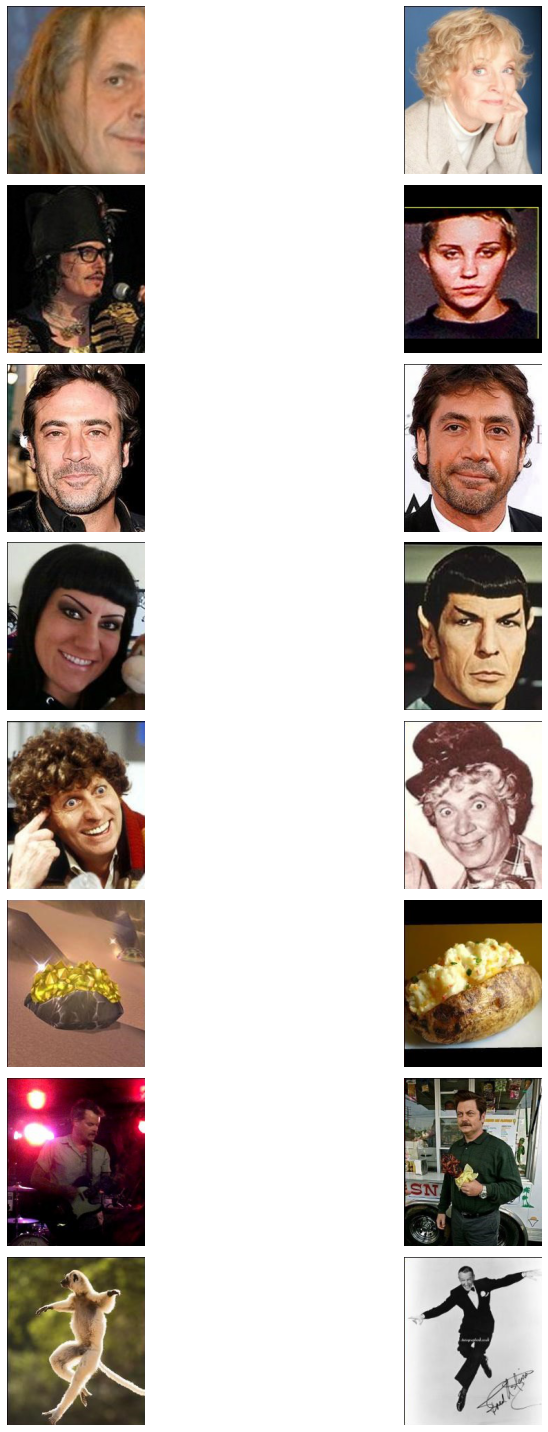

In [101]:
import matplotlib.pyplot as plt
import random

df_output = pd.read_csv("cosdists_net121_MobileNet_cosTripletloss.csv")
top_8_rows = df_output.head(8)


# Read test_candidates.csv
df_candidates = pd.read_csv("test_candidates.csv")

# Extract 8 random rows
# for reuse purpose 
random.seed(42)
random_rows = random.sample(range(df_output.shape[0]), 8)

# Function to display image
def display_image(img_name, left=True):
    if left:
        img_path = os.path.join(test_left_image_path, img_name)
    else:
        img_path = os.path.join(test_right_image_path, img_name)
    img = plt.imread(img_path + ".jpg")
    plt.imshow(img)
    plt.axis('off')


# plot 8 pairs of images
#plt.figure(figsize=(16, 20))

# plot 8 pairs of images
fig, axes = plt.subplots(8, 2, figsize=(16, 20))
# adjust spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.3)

for idx, row_num in enumerate(random_rows, 1):
    # extract row from df_output
    row = df_output.iloc[row_num]
    original_image = row['left']
    similarities = row[['c' + str(i) for i in range(20)]].astype(float)

    
    # find the column with maximum similarity and get corresponding image name from df_candidates
    max_sim_col = similarities.idxmax()
    most_similar_image = df_candidates.iloc[row_num][max_sim_col]
    
    # plot original image (left)
    plt.subplot(8, 2, 2*idx-1)
    display_image(original_image, left=True)
    
    # plot most similar image (right candidate)
    plt.subplot(8, 2, 2*idx)
    display_image(most_similar_image, left=False)

plt.tight_layout()
plt.show()



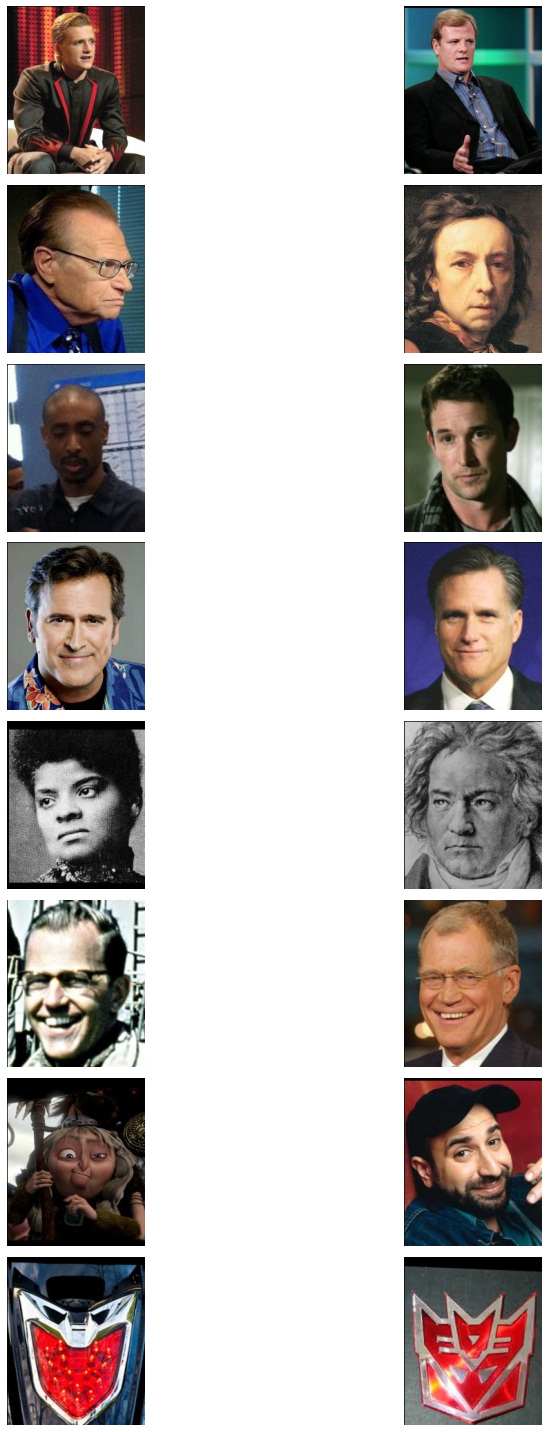

In [125]:
import matplotlib.pyplot as plt
import random

df_output = pd.read_csv("cosdists_net121_MobileNet_cosTripletloss.csv")
top_8_rows = df_output.head(8)


# Read test_candidates.csv
df_candidates = pd.read_csv("test_candidates.csv")

# Extract 8 random rows
random.seed(84)
random_rows = random.sample(range(df_output.shape[0]), 8)

# Function to display image
def display_image(img_name, left=True):
    if left:
        img_path = os.path.join(test_left_image_path, img_name)
    else:
        img_path = os.path.join(test_right_image_path, img_name)
    img = plt.imread(img_path + ".jpg")
    plt.imshow(img)
    plt.axis('off')


# Plot 8 pairs of images
#plt.figure(figsize=(16, 20))

# Plot 8 pairs of images
fig, axes = plt.subplots(8, 2, figsize=(16, 20))
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.3)

for idx, row_num in enumerate(random_rows, 1):
    # Extract row from df_output
    row = df_output.iloc[row_num]
    original_image = row['left']
    similarities = row[['c' + str(i) for i in range(20)]].astype(float)

    
    # Find the column with maximum similarity and get corresponding image name from df_candidates
    max_sim_col = similarities.idxmax()
    most_similar_image = df_candidates.iloc[row_num][max_sim_col]
    
    # Plot original image (left)
    plt.subplot(8, 2, 2*idx-1)
    display_image(original_image, left=True)
    
    # Plot most similar image (right candidate)
    plt.subplot(8, 2, 2*idx)
    display_image(most_similar_image, left=False)

plt.tight_layout()
plt.show()



## score 0.524 
## densenet121，cosine triplet loss，csidt

In [ ]:
train_dir_path = "train"
test_dir_path = "test"

train_left_image_path = os.path.join(train_dir_path, "left")
train_right_image_path = os.path.join(train_dir_path, "right")

test_left_image_path = os.path.join(test_dir_path, "left")
test_right_image_path = os.path.join(test_dir_path, "right")

In [ ]:

# 1. prepare 
densenet121 = DenseNet121(weights='imagenet', include_top=False)

def extract_features(img_path, model):
    img_path_with_extension = img_path + ".jpg"  # Append .jpg extension
    img = load_img(img_path_with_extension, target_size=(200, 245))
    img_array = img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    return model.predict(preprocessed_img).flatten()


precomputed_features = {}
def get_features(img_path):
    if img_path not in precomputed_features:
        precomputed_features[img_path] = extract_features(img_path, densenet121)
    return precomputed_features[img_path]

def prepare_features_and_labels(train_left_image_path, train_right_image_path, train_csv_path):
    train_df = pd.read_csv(train_csv_path)
    all_right_images = train_df["right"].unique()
    
    anchors, positives, negatives = [], [], []

    for _, row in train_df.iterrows():
        anchor_img_path = os.path.join(train_left_image_path, row["left"])
        positive_img_path = os.path.join(train_right_image_path, row["right"])

        negative_img_path = np.random.choice(
            list(set(all_right_images) - set([row["right"]]))
        )
        negative_img_path = os.path.join(train_right_image_path, negative_img_path)

        anchors.append(get_features(anchor_img_path))
        positives.append(get_features(positive_img_path))
        negatives.append(get_features(negative_img_path))

    return np.array(anchors), np.array(positives), np.array(negatives)


# 2. build model

def cosine_distance(vests):
    x, y = vests
    x = tf.nn.l2_normalize(x, axis=-1)
    y = tf.nn.l2_normalize(y, axis=-1)
    return -tf.reduce_sum(x * y, axis=-1, keepdims=True)

def cosine_distance_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def cosine_triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, :feature_length], y_pred[:, feature_length:2*feature_length], y_pred[:, 2*feature_length:]

    positive_distance = cosine_distance([anchor, positive])
    negative_distance = cosine_distance([anchor, negative])
        
    basic_loss = positive_distance - negative_distance + alpha
    return tf.reduce_mean(tf.maximum(basic_loss, 0.0))


def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(1024, activation='relu')(input)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    return Model(input, x)



In [ ]:
anchors, positives, negatives = prepare_features_and_labels(
    train_left_image_path, train_right_image_path, "train.csv"
)


In [ ]:
'''train model '''

feature_length = anchors.shape[1]
base_network = create_base_network((feature_length,))

input_anchor = Input(shape=(feature_length,))
input_positive = Input(shape=(feature_length,))
input_negative = Input(shape=(feature_length,))

processed_anchor = base_network(input_anchor)
processed_positive = base_network(input_positive)
processed_negative = base_network(input_negative)


def cosine_distance_difference(tensors):
    anchor, positive, negative = tensors
    positive_distance = cosine_distance([anchor, positive])
    negative_distance = cosine_distance([anchor, negative])
    return tf.nn.relu(positive_distance - negative_distance)

distance_difference = Lambda(cosine_distance_difference)([processed_anchor, processed_positive, processed_negative])
prediction = Dense(1, activation='sigmoid')(distance_difference)

# distance = Lambda(cosine_distance, output_shape=cosine_distance_output_shape)([processed_anchor, processed_positive, processed_negative])
# prediction = Dense(1, activation='sigmoid')(distance)
siamese_net = Model([input_anchor, input_positive, input_negative], prediction)
siamese_net.compile(optimizer='adam', loss=cosine_triplet_loss)
#siamese_net.compile(optimizer='adam', loss=cosine_triplet_loss, run_eagerly=True)

X_train_anchor, X_val_anchor, X_train_positive, X_val_positive, X_train_negative, X_val_negative = train_test_split(
    anchors, positives, negatives, test_size=0.3, random_state=42
)

checkpoint = ModelCheckpoint(filepath="best_weights.h5", save_best_only=True, save_weights_only=True)

y_train_dummy = np.zeros((X_train_anchor.shape[0], 1))
y_val_dummy = np.zeros((X_val_anchor.shape[0], 1))
siamese_net.fit(
    [X_train_anchor, X_train_positive, X_train_negative], 
    y_train_dummy, 
    validation_data=([X_val_anchor, X_val_positive, X_val_negative], y_val_dummy),
    batch_size=32, epochs=15, callbacks=[checkpoint]
)



In [ ]:
######### 


# 3. predict
output_data = []
test_candidates_df = pd.read_csv("test_candidates.csv")

for index, row in test_candidates_df.iterrows():
    left_image_path = os.path.join(test_left_image_path, row["left"])
    left_features = get_features(left_image_path).reshape((1, feature_length))

    right_features_list = []
    for i in range(20):  # 20个candidates
        right_image_path = os.path.join(test_right_image_path, row[f"c{i}"])
        right_features_list.append(get_features(right_image_path).reshape((feature_length,)))

    # calcaulate dists
    distances = cdist(left_features, np.array(right_features_list), metric='cosine').reshape((20,))

    
    confidences = 1 - distances  # get confidence

    output_data.append([row["left"]] + list(confidences))

# 4. save "sample_output"
df_output = pd.DataFrame(output_data, columns=["left"] + [f"c{i}" for i in range(20)])
df_output.to_csv("cosdists_net121_cosTripletloss_facialfeatureSelect.csv", index=False)
